In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import shap
import uuid

In [152]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv') #load dataset

In [153]:
print(df.head())  # First 5 rows
print(df.info())  # Data types and non-null counts
print(df.describe())  # Summary statistics for numerical features
print(df.isnull().sum())  # Missing values

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [154]:
# Quantify Attrition class imbalance
print("\nAttrition Class Distribution:")
print(df['Attrition'].value_counts(normalize=True))


Attrition Class Distribution:
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


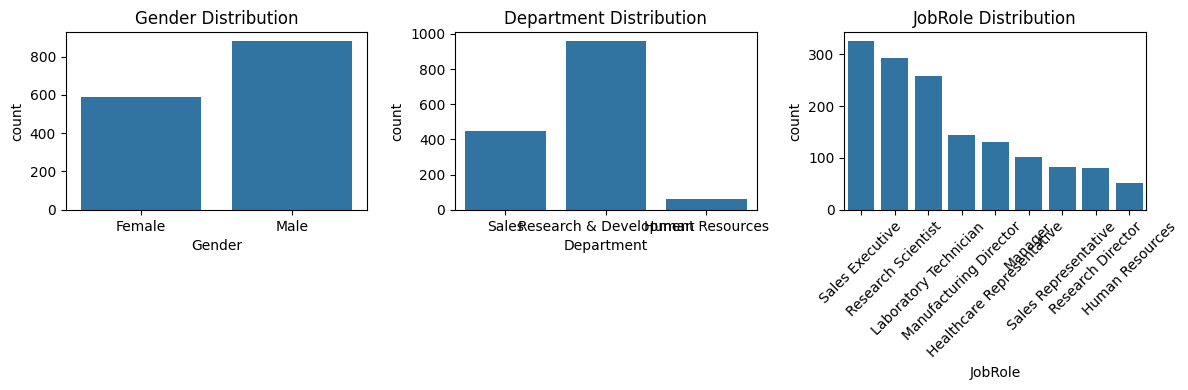

In [155]:
# Univariate analysis for additional features
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.subplot(1, 3, 2)
sns.countplot(x='Department', data=df)
plt.title('Department Distribution')
plt.subplot(1, 3, 3)
sns.countplot(x='JobRole', data=df)
plt.title('JobRole Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

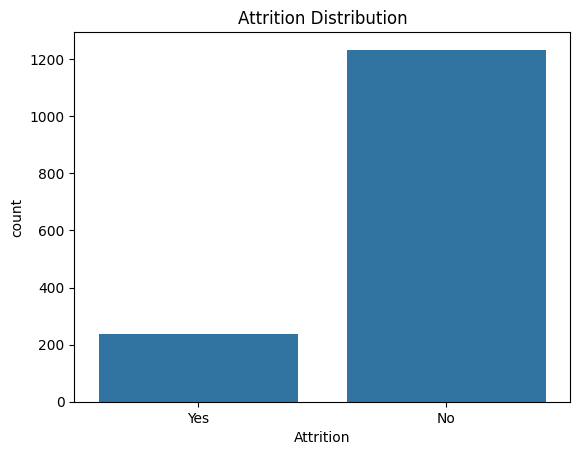

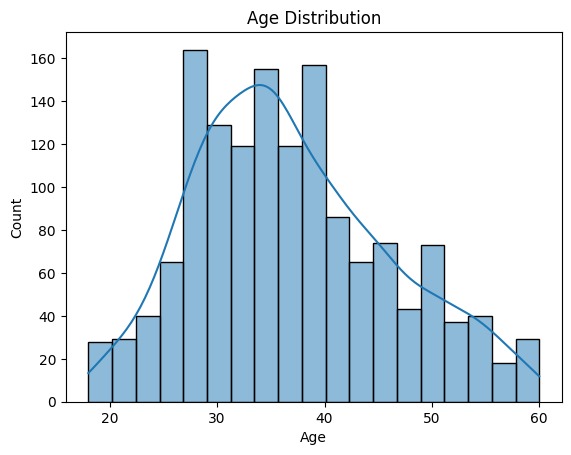

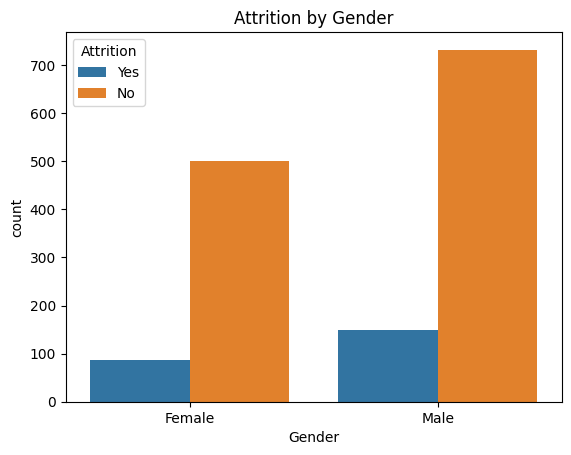

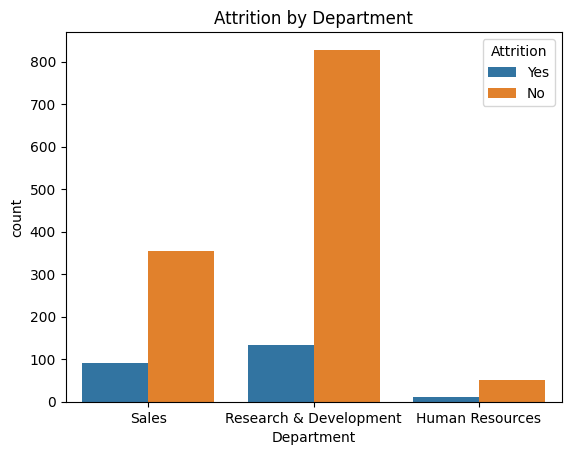

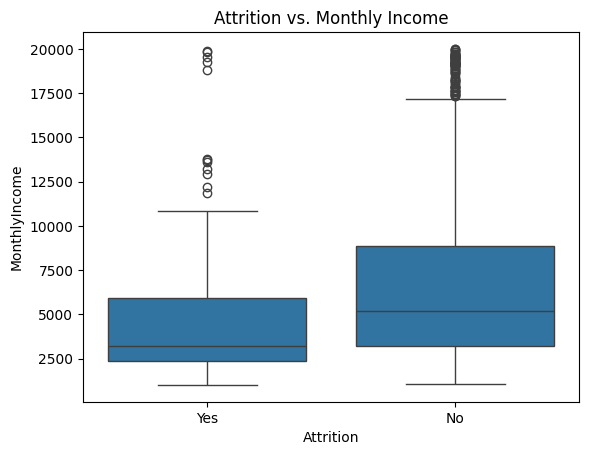

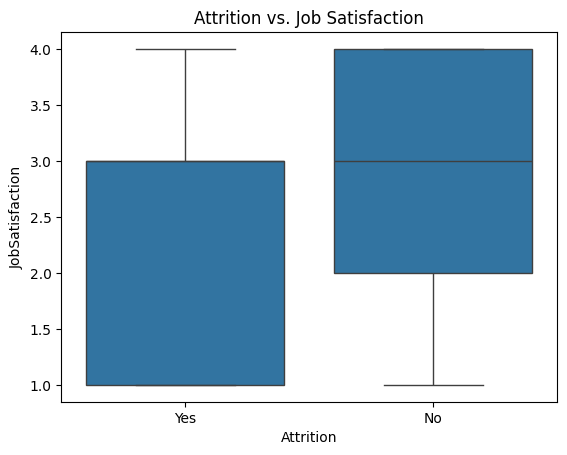

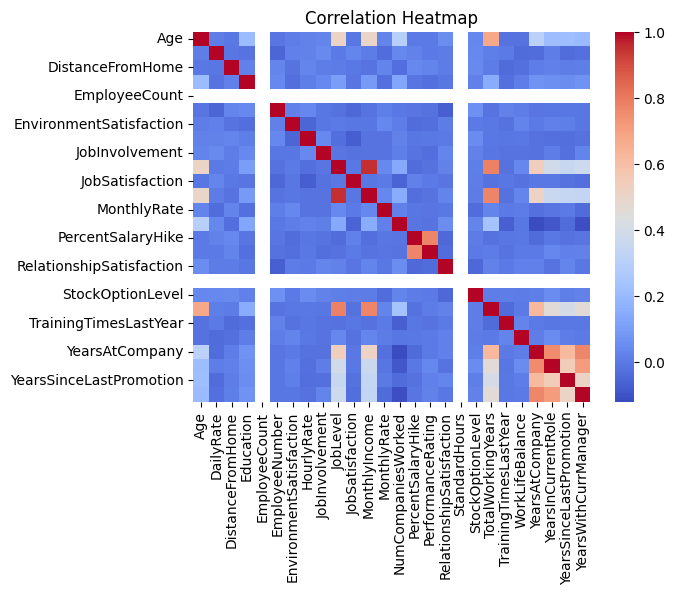

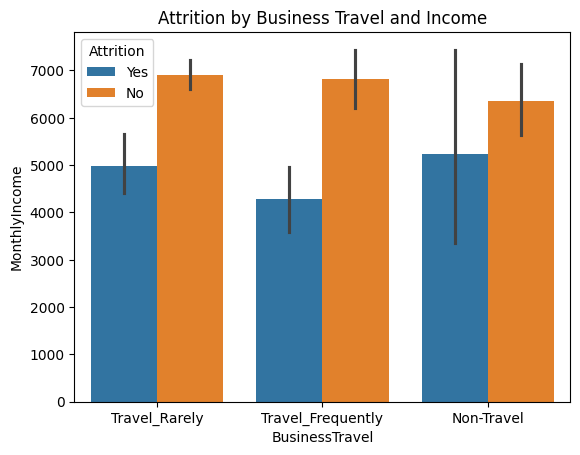

In [156]:
# Attrition distribution
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Attrition by Gender
sns.countplot(x='Gender', hue='Attrition', data=df)
plt.title('Attrition by Gender')
plt.show()

# Attrition by Department
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Attrition by Department')
plt.show()

# Attrition vs. MonthlyIncome
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Attrition vs. Monthly Income')
plt.show()

# Attrition vs. JobSatisfaction
sns.boxplot(x='Attrition', y='JobSatisfaction', data=df)
plt.title('Attrition vs. Job Satisfaction')
plt.show()

# Correlation heatmap (numerical features only)
numerical_df = df.select_dtypes(include=['int64', 'float64'])
corr = numerical_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Bar plot: Attrition by BusinessTravel
sns.barplot(x='BusinessTravel', y='MonthlyIncome', hue='Attrition', data=df)
plt.title('Attrition by Business Travel and Income')
plt.show()

In [157]:
# Detect outliers in numerical features using IQR
numerical_cols = ['MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

In [158]:
# Label encode binary target
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])  # Yes=1, No=0

# Encode OverTime as binary
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Columns after one-hot encoding:", df.columns.tolist())

# Drop irrelevant columns
df.drop(['EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1, inplace=True)

Columns after one-hot encoding: ['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Male', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_R

In [159]:
# Feature engineering
df['PromotionGap'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']
df['TenureBand'] = pd.cut(df['YearsAtCompany'], bins=[-float('inf'), 2, 5, float('inf')], labels=['Short', 'Medium', 'Long'])
df = pd.get_dummies(df, columns=['TenureBand'], drop_first=True)
df['WorkLifeBalanceIndex'] = (df['WorkLifeBalance'] + df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['OverTime']) / 4

# Scale numerical features
numerical_cols = [
    'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
    'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'PromotionGap', 'WorkLifeBalanceIndex', 'OverTime'
]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print("Feature Stats Before Scaling:", df[numerical_cols].describe())

Feature Stats Before Scaling:                 Age     DailyRate  DistanceFromHome     Education  \
count  1.304000e+03  1.304000e+03      1.304000e+03  1.304000e+03   
mean   3.919837e-16 -1.062545e-16      7.356079e-17  1.743663e-16   
std    1.000384e+00  1.000384e+00      1.000384e+00  1.000384e+00   
min   -2.029981e+00 -1.746615e+00     -1.025049e+00 -1.865070e+00   
25%   -6.799499e-01 -8.348535e-01     -9.008930e-01 -8.863771e-01   
50%   -7.674438e-02  3.568940e-03     -2.801128e-01  9.231532e-02   
75%    4.977371e-01  8.761747e-01      5.889795e-01  1.071008e+00   
max    2.795663e+00  1.726406e+00      2.451320e+00  2.049700e+00   

       EnvironmentSatisfaction    HourlyRate  JobInvolvement      JobLevel  \
count             1.304000e+03  1.304000e+03    1.304000e+03  1.304000e+03   
mean             -1.396293e-16  1.907132e-16    1.689174e-16  1.076167e-16   
std               1.000384e+00  1.000384e+00    1.000384e+00  1.000384e+00   
min              -1.573950e+00 -1.77

In [160]:
# Train-test split
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Calculate sample weights to balance department
department_cols = [col for col in X_train.columns if col.startswith('Department_')]
dept_counts = X_train[department_cols].sum()
total_samples = len(X_train)
sample_weights = X_train[department_cols].apply(lambda x: total_samples / (len(department_cols) * dept_counts[x.idxmax()]), axis=1).fillna(1.0)

In [161]:
# Baseline models
import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

lr_weighted = LogisticRegression(class_weight='balanced', random_state=42)
lr_weighted.fit(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Advanced models
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='auc')
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 181, number of negative: 862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173538 -> initscore=-1.560758
[LightGBM] [Info] Start training from score -1.560758


In [162]:
# Handle class imbalance
# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='auc')
xgb_model.fit(X_train_smote, y_train_smote)  # Fit the XGBClassifier
xgb_model_smote = CalibratedClassifierCV(xgb_model, method='isotonic', cv=5)
xgb_model_smote.fit(X_train_smote, y_train_smote)



,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [163]:
# Hyperparameter tuning
# Random Forest
import warnings
warnings.filterwarnings('ignore')

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train_smote, y_train_smote)
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Params:", grid_search_rf.best_params_)

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1]
}
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='auc'), param_grid_xgb, cv=5, scoring='roc_auc')
grid_search_xgb.fit(X_train_smote, y_train_smote)
best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost Params:", grid_search_xgb.best_params_)

# LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, -1],
    'learning_rate': [0.01, 0.1]
}
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=5, scoring='roc_auc')
grid_search_lgb.fit(X_train_smote, y_train_smote)
best_lgb = grid_search_lgb.best_estimator_

# CatBoost
param_grid_cat = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],

    'learning_rate': [0.01, 0.1]
}
grid_search_cat = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid_cat, cv=5, scoring='roc_auc')
grid_search_cat.fit(X_train_smote, y_train_smote)
best_cat = grid_search_cat.best_estimator_
print("Best CatBoost Params:", grid_search_cat.best_params_)

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 690, number of negative: 689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 1379, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500363 -> initscore=0.001450
[LightGBM] [Info] Start training from score 0.001450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [164]:
# Save model and preprocessors for deployment
import os
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(xgb_model_smote, 'models/xgb_model_smote.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(X_train.columns, 'models/feature_columns.pkl')

['models/feature_columns.pkl']

In [165]:
# Cost-sensitive evaluation function
def evaluate_model_cost_sensitive(model, X_test, y_test, model_name="Model", fn_cost=5, fp_cost=1):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(f'\n=== {model_name} Evaluation ===')
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', cm)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    print('PR-AUC:', auc(recall, precision))
    
    # Cost-sensitive evaluation
    tn, fp, fn, tp = cm.ravel()
    total_cost = fn * fn_cost + fp * fp_cost
    print('Total Cost (FN*5 + FP*1):', total_cost)

# Evaluate all models
if 'Pred' in X_test.columns or 'Actual' in X_test.columns:
    X_test = X_test.drop(['Pred', 'Actual'], axis=1, errors='ignore')
    
X_test_clean = X_test.copy()

evaluate_model_cost_sensitive(xgb_model_smote, X_test, y_test, "XGBoost with SMOTE")
evaluate_model_cost_sensitive(best_xgb, X_test, y_test, "Tuned XGBoost")
evaluate_model_cost_sensitive(best_cat, X_test, y_test, "Tuned CatBoost")
evaluate_model_cost_sensitive(best_lgb, X_test, y_test, "Tuned LightGBM")
evaluate_model_cost_sensitive(dt, X_test, y_test, "Decision Tree")
evaluate_model_cost_sensitive(rf, X_test, y_test, "Random Forest")
evaluate_model_cost_sensitive(best_rf, X_test, y_test, "Tuned Random Forest")
evaluate_model_cost_sensitive(lr, X_test, y_test, "Logistic Regression")
evaluate_model_cost_sensitive(lr_weighted, X_test, y_test, "Logistic Regression (Weighted)")


=== XGBoost with SMOTE Evaluation ===
Confusion Matrix:
 [[210   6]
 [ 36   9]]
Accuracy: 0.8390804597701149
Precision: 0.6
Recall: 0.2
F1 Score: 0.3
ROC-AUC: 0.770679012345679
PR-AUC: 0.5217645991401333
Total Cost (FN*5 + FP*1): 186

=== Tuned XGBoost Evaluation ===
Confusion Matrix:
 [[205  11]
 [ 29  16]]
Accuracy: 0.8467432950191571
Precision: 0.5925925925925926
Recall: 0.35555555555555557
F1 Score: 0.4444444444444444
ROC-AUC: 0.7468106995884773
PR-AUC: 0.4799523851338607
Total Cost (FN*5 + FP*1): 156

=== Tuned CatBoost Evaluation ===
Confusion Matrix:
 [[208   8]
 [ 30  15]]
Accuracy: 0.8544061302681992
Precision: 0.6521739130434783
Recall: 0.3333333333333333
F1 Score: 0.4411764705882353
ROC-AUC: 0.7799382716049382
PR-AUC: 0.5274627976740248
Total Cost (FN*5 + FP*1): 158

=== Tuned LightGBM Evaluation ===
Confusion Matrix:
 [[206  10]
 [ 33  12]]
Accuracy: 0.8352490421455939
Precision: 0.5454545454545454
Recall: 0.26666666666666666
F1 Score: 0.3582089552238806
ROC-AUC: 0.7496913

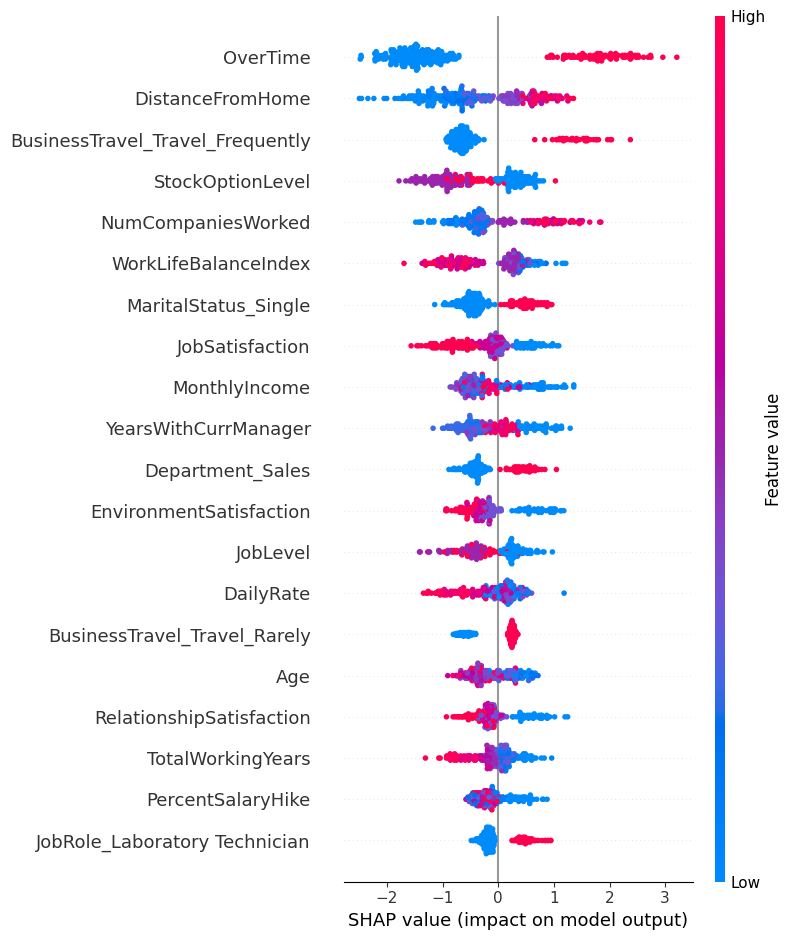

In [166]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)



In [167]:
# Actionable HR insights
print("\n=== Actionable HR Insights ===")
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
top_features = shap_df.abs().mean().sort_values(ascending=False).head(3).index
print("Top 3 influential features for attrition:", top_features.tolist())
for feature in top_features:
    # Check if feature is numerical (float64 or int64)
    if X_test[feature].dtype in ['float64', 'int64']:
        high_risk = X_test[X_test[feature] < X_test[feature].quantile(0.25)]
        attrition_rate = xgb_model_smote.predict(high_risk).mean() if not high_risk.empty else 0
        print(f"Employees with low {feature} (bottom 25%) have an attrition rate of {attrition_rate:.2%}")
    # Handle boolean/categorical features (e.g., OverTime_Yes, Department_)
    elif X_test[feature].dtype == 'bool' or feature in [col for col in X_test.columns if col.startswith(('OverTime_', 'Department_', 'JobRole_'))]:
        high_risk = X_test[X_test[feature] == 1]
        attrition_rate = xgb_model_smote.predict(high_risk).mean() if not high_risk.empty else 0
        print(f"Employees with {feature}=1 have an attrition rate of {attrition_rate:.2%}")


=== Actionable HR Insights ===
Top 3 influential features for attrition: ['OverTime', 'DistanceFromHome', 'BusinessTravel_Travel_Frequently']
Employees with low OverTime (bottom 25%) have an attrition rate of 0.00%
Employees with low DistanceFromHome (bottom 25%) have an attrition rate of 4.55%
Employees with BusinessTravel_Travel_Frequently=1 have an attrition rate of 9.76%


In [169]:
import numpy as np
X_test_clean['Pred'] = xgb_model_smote.predict(X_test_clean)
X_test_clean['Actual'] = y_test

# Bias by Gender
print("\n=== Bias Analysis: Gender ===")
gender_rates = X_test_clean.groupby('Gender_Male')['Pred'].mean()
print(gender_rates)
di_gender = gender_rates[1] / gender_rates[0] if gender_rates[0] != 0 else np.inf
print('Disparate Impact (Gender):', di_gender)

# Bias by Age
X_test_clean['AgeGroup'] = pd.cut(X_test_clean['Age'], bins=[-float('inf'), -0.5, 0.5, float('inf')], labels=['Young', 'Middle', 'Senior'])
print("\n=== Bias Analysis: Age ===")
age_rates = X_test_clean.groupby('AgeGroup')['Pred'].mean()
print(age_rates)
di_age = age_rates['Young'] / age_rates['Senior'] if age_rates['Senior'] != 0 else np.inf
print('Disparate Impact (Age: Young vs Senior):', di_age)

# Bias by Department
department_cols = [col for col in X_test_clean.columns if col.startswith('Department_')]
print("\n=== Bias Analysis: Department ===")
dept_rates = {}
for col in department_cols:
    rate = X_test_clean[X_test_clean[col] == 1]['Pred'].mean()
    dept_rates[col] = rate if not pd.isna(rate) else 0
    print(f"Attrition rate for {col}:", dept_rates[col])
# Compute Disparate Impact for departments
if dept_rates:
    valid_rates = [r for r in dept_rates.values() if r != 0]
    max_rate = max(valid_rates) if valid_rates else 0
    min_rate = min(valid_rates) if valid_rates else 0
    di_dept = max_rate / min_rate if min_rate != 0 else np.inf
    print('Disparate Impact (Department: Max vs Min):', di_dept)

# SHAP-based bias check
print("\n=== SHAP-Based Bias Check ===")
bias_features = ['Gender_Male', 'Age'] + department_cols
for feature in bias_features:
    if feature in shap_df.columns:
        mean_shap = shap_df[feature].abs().mean()
        print(f"Mean SHAP value for {feature}: {mean_shap:.4f}")

# Mitigation strategies
print("\n=== Bias Mitigation Strategies ===")
if di_gender < 0.8 or di_gender > 1.25:
    print("Gender bias detected (Disparate Impact outside 0.8-1.25). Mitigation strategies:")
    print("- Adjust prediction thresholds to balance outcomes across genders (e.g., lower threshold for underrepresented group).")
    print("- Reweight training samples to reduce gender influence using sample weights.")
    print("- Remove Gender_Male feature if it’s unfairly influential or use fairness-aware algorithms like Fairlearn.")
if di_age < 0.8 or di_age > 1.25:
    print("Age bias detected. Mitigation strategies:")
    print("- Apply fairness-aware algorithms like Fairlearn to constrain disparate impact.")
    print("- Add age-based reweighting in training to balance outcomes across age groups.")
    print("- Adjust model to include age interactions to capture nuanced effects.")
if 'di_dept' in locals() and (di_dept < 0.8 or di_dept > 1.25):
    print("Department bias detected. Mitigation strategies:")
    print("- Reweight samples by department to balance training data representation.")
    print("- Use post-processing techniques to adjust predictions for departments with high disparity.")
    print("- Review department-related features for potential bias amplification.")


=== Bias Analysis: Gender ===
Gender_Male
False    0.071429
True     0.049080
Name: Pred, dtype: float64
Disparate Impact (Gender): 0.6871165644171779

=== Bias Analysis: Age ===
AgeGroup
Young     0.150538
Middle    0.010204
Senior    0.000000
Name: Pred, dtype: float64
Disparate Impact (Age: Young vs Senior): inf

=== Bias Analysis: Department ===
Attrition rate for Department_Research & Development: 0.03428571428571429
Attrition rate for Department_Sales: 0.08860759493670886
Disparate Impact (Department: Max vs Min): 2.5843881856540083

=== SHAP-Based Bias Check ===
Mean SHAP value for Gender_Male: 0.2151
Mean SHAP value for Age: 0.3346
Mean SHAP value for Department_Research & Development: 0.0456
Mean SHAP value for Department_Sales: 0.4308

=== Bias Mitigation Strategies ===
Gender bias detected (Disparate Impact outside 0.8-1.25). Mitigation strategies:
- Adjust prediction thresholds to balance outcomes across genders (e.g., lower threshold for underrepresented group).
- Reweigh

In [51]:
import joblib
import os